# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [ ]:
Como obtener las calificaciones:
Según la cantidad de compras de ese producto, hacer un valor ponderado.


#### **Basado en contenidos**

Idea: recomendar ítems al usuario que sean similares a aquellos que
puntuó positivamente antes (o, en su defecto, que consumió).

1. Para cada ítem, debemos construir un perfil.
a. Casos sencillos: información fácilmente disponible. Películas: director, género,
actores, año, etc.
b. Casos no-sencillos. Debemos extraer features de los ítems. Noticias: hay que
usar la batería de herramientas de NLP (tf-idf, etc.)

2. Idealmente, también hay que construir un perfil de qué cosas le gustan al usuario.
3. Usamos una métrica de distancia para encontrar ítems similares.
a. Índice Jaccard
b. Distancia coseno
4. Recomendamos

In [1]:
### Importamos librerias
import gzip
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
#Barra de progreso
##conda install tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm
from surprise import Reader, Dataset, SVD




def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('data/steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [4]:
if True:
    data_reviews.to_csv('data/data_reviews.csv', index= False)

#### Cargamos el dataset

In [2]:
data_reviews = pd.read_csv('data/data_reviews.csv')
data_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


We crawled reviews and game information from Steam. The dataset contains 7,793,069 reviews, 2,567,538 users, and 32,135 games. In addition to the review text, the data also includes the users' play hours in each review.

In [6]:
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [7]:
## Tamaño del dataset
data_reviews.shape

(779307, 12)

In [8]:
### Cantidad de valoraciónes de un juego especifico
data_reviews[data_reviews.product_id == '35140']

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny


**Games**

In [2]:
data_games = []
for l in parse('data/steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [30]:
if True:
    data_games.to_csv('data/data_games.csv', index= False)

In [3]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [32]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [33]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [34]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [35]:
## Tamaño del dataset
data_games.shape

(32135, 16)

In [36]:
#Don't drop, just take the rows where EPS is not NA:
data_games = data_games[data_games['id'].notna()]
data_games['id'] = data_games['id'].astype('int')
data_games.reset_index(inplace=True)

#### Seleccionamos las features relevantes de los dataset para posterior hacer un merge entre ambos y trabajar con uno solo

In [37]:
data_reviews = data_reviews[['product_id','username', 'hours', 'products']]

In [42]:
data_games = data_games[['id','app_name','price','genres','tags','specs']]

In [43]:
data_reviews.head(3)

,product_id,username,hours,products
0,725280,Chaos Syren,0.1,41.0
1,328100,Ariman1,13.2,1386.0
2,725280,freakfantom,0.1,1706.0


In [44]:
data_games.head(3)

,id,app_name,price,genres,tags,specs
0,761140,Lost Summoner Kitty,4.99,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player]
1,643980,Ironbound,Free To Play,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla..."
2,670290,Real Pool 3D - Poolians,Free to Play,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla..."


#### Realizo merge de los dos dataset

Agregamos al dataset el nombre del Juego, se utiliza la columna en común que identifica a los juegos en ambos dataset, product_id y id

In [45]:
#https://interactivechaos.com/es/manual/tutorial-de-pandas/dataframes-la-funcion-merge
mergeado = pd.merge(data_reviews,data_games, left_on = "product_id", right_on = "id")
mergeado.drop('id', axis=1, inplace=True)
mergeado.head()

,product_id,username,hours,products,app_name,price,genres,tags,specs
0,725280,Chaos Syren,0.1,41.0,Psi Project,2.99,"[Action, Adventure, Indie, Simulation]","[Action, Adventure, Indie, Simulation]","[Single-player, Steam Trading Cards]"
1,725280,freakfantom,0.1,1706.0,Psi Project,2.99,"[Action, Adventure, Indie, Simulation]","[Action, Adventure, Indie, Simulation]","[Single-player, Steam Trading Cards]"
2,328100,Ariman1,13.2,1386.0,Gunspell - Steam Edition,14.99,"[Adventure, Indie, RPG]","[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player]
3,328100,dll3z,0.4,314.0,Gunspell - Steam Edition,14.99,"[Adventure, Indie, RPG]","[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player]
4,328100,Nyazicat,2.2,1224.0,Gunspell - Steam Edition,14.99,"[Adventure, Indie, RPG]","[Adventure, RPG, Indie, Puzzle, Match 3]",[Single-player]


In [46]:
if True:
    mergeado.to_csv('data/mergeado.csv', index= False)

#### Cargamos el Dataset, que ya contiene un merge con las reviews y games. Además cargamos el dataset data_games

In [2]:
df = pd.read_csv('data/mergeado.csv')
data_games = pd.read_csv('data/data_games.csv')
#df.head(2)

In [3]:
## Tamaño del dataset
df.shape

(779951, 9)

In [4]:
df1 = df[['product_id','username','app_name','price','hours']]
df1

,product_id,username,app_name,price,hours
0,725280,Chaos Syren,Psi Project,2.99,0.1
1,725280,freakfantom,Psi Project,2.99,0.1
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
...,...,...,...,...,...
779946,518790,rt974,theHunter: Call of the Wild™,29.99,9.4
779947,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8
779948,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4
779949,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9


In [5]:
cnt_de_juegos = df1['product_id'].unique().size
cnt_usuarios = df1['username'].unique().size
print("El dataset tiene {} juegos y {} usuarios".format(cnt_de_juegos,cnt_usuarios))

El dataset tiene 12665 juegos y 540339 usuarios


#### Cantidad de videos Juegos por usuarios

In [6]:
df1 = df[['product_id','username','app_name','price','hours']]

In [7]:
Pop_rec = df1.groupby(['username'], as_index=False)['product_id'].count()

In [9]:
#mergeado.groupby(['product_id'], as_index=False)['username'].count().sort_values(['username'], ascending=False).head(10)
#data2 = df.groupby(['username'], as_index=False)['product_id'].count().sort_values(['product_id'], ascending=False)
#data2 = df.groupby(['username'], as_index=False)['product_id'].count()

In [10]:
Pop_rec.rename(columns={'product_id': 'cnt_juegosxusuarios'}, inplace=True)
#data2.head(20).sort_values(['cnt_juegosxusuarios'], ascending=False).head(10)
Pop_rec.head(10)

,username,cnt_juegosxusuarios
0,!,1
1,! ZerZ,2
2,! ! ŦŕĩŽǿЯëќ™ ! !,1
3,! Alga,2
4,! DeadlyDeal !,1
5,! Dr Feelgood,1
6,! EREN,1
7,! GRIFFIS,1
8,! Monika !,2
9,! Taz the Husky,4


In [11]:
#Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False).describe()

In [12]:
Pop_rec_sort = Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False)
Pop_rec_sort.describe()

,cnt_juegosxusuarios
count,540338.000000
mean,1.443417
std,1.928097
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,213.000000


In [13]:
data_top = Pop_rec.sort_values(['cnt_juegosxusuarios'], ascending=False).head(100)

In [14]:
data_top.describe()

,cnt_juegosxusuarios
count,100.000000
mean,77.410000
std,28.921033
min,51.000000
25%,57.750000
50%,68.000000
75%,88.750000
max,213.000000


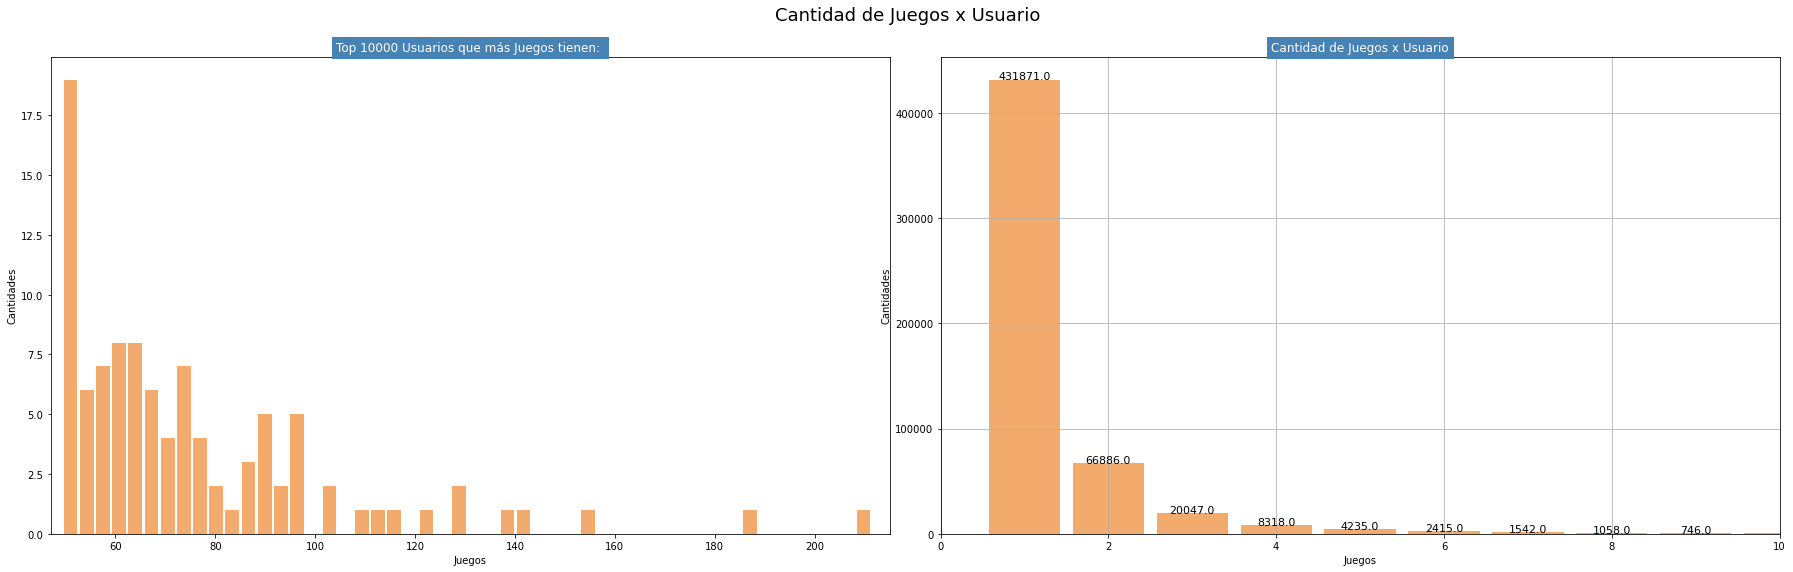

In [15]:
intervalos = range(min(Pop_rec_sort.cnt_juegosxusuarios), max(Pop_rec_sort.cnt_juegosxusuarios) + 2) #calculamos los extremos de los intervalos

## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Cantidad de Juegos x Usuario', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)
plt.grid()

# Grafico 0
#sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
axes[0].set_title("Top 10000 Usuarios que más Juegos tienen: ",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[0].hist(x=data_top.cnt_juegosxusuarios, bins=50, color='#F2AB6D', rwidth=0.85, align='left')
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes[0].set_xlabel("Juegos")
axes[0].set_ylabel("Cantidades")
axes[0].set_xlim([47,215]) ## limite en x, para acotar y quitar los outliers

#count=0
#for rect in axes[0].patches:
#    count +=1
#    if count < 12:  
#        # prints the quit message
#        #print(quit)
#        axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)


#Grafico 1

axes[1].set_title("Cantidad de Juegos x Usuario",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[1].hist(x=Pop_rec_sort.cnt_juegosxusuarios, bins=intervalos, color='#F2AB6D', rwidth=0.85, align='left')
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=0)
axes[1].set_xlabel("Juegos")
axes[1].set_ylabel("Cantidades")
axes[1].set_xlim([0,10]) ## limite en x, para acotar y quitar los outliers

count=0
for rect in axes[1].patches:
    count +=1
    if count < 10:  
        axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

En el gráfico de la izaquieda observamos el top 10000 de los usuarios que han comprado más juego y su distribución. Se observa que el 67.8% ha comprado por 5 juegos, y 1.5% ha comprada 10 juegos. El gráfico de la derecha se grafica todos los datos, el 55% de los usuarios ha comprado 1 Juego, el 8.5% 2 Juegos y el 1% 3 Juegos.

In [16]:
#print('Popularity Based Model')

In [17]:
df1

,product_id,username,app_name,price,hours
0,725280,Chaos Syren,Psi Project,2.99,0.1
1,725280,freakfantom,Psi Project,2.99,0.1
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
...,...,...,...,...,...
779946,518790,rt974,theHunter: Call of the Wild™,29.99,9.4
779947,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8
779948,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4
779949,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9


#### El Juego más comprado es el más Jugado?

Vamos a determisnar si el juego más comprado se corresponde con el más jugado. Por cada juego, vamos a computar el total de usuarios y el total de tiempo por juego por todos los usuarios. El resultado lo mostraremos a continuacion, solo mostraremos el top 20 de los juegos con más horas/usuarios.

Usamos un Histograma para visualizar el resultado de la tabla de abajo. Los Juegos están ordenados de forma decreciente basado en el número de usuarios. El color del gradiente representa el total de horas jugadas.

Podemos usar la tabla de abajo para comparar con el Histograma si se mantiene el order y la lógica, juego más jugado es el que tiene más usuarios. Para verlo más claro y en un mismo gráfico se hace el histograma que contempla las dos variables, eje x la cantidad de usuarios y el color del gradiente es según la cantidad de horas jugadas.

In [18]:
# Top de juegos más jugados según el número de horas
top = 20
game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:top]
most_played_games.head(20)

app_name
Team Fortress 2                13306145.4
Rust                            4443474.6
Warframe                        3406654.9
Garry's Mod                     2629495.2
Arma 3                          2573904.2
ARK: Survival Evolved           2275927.5
Fallout 4                       1635305.7
Mount & Blade: Warband          1446695.2
Counter-Strike: Source          1417299.9
DayZ                            1348023.4
Grand Theft Auto V              1288376.5
Borderlands 2                   1236835.4
Sid Meier's Civilization® V     1218226.8
H1Z1                            1036892.9
Clicker Heroes                   907883.0
FINAL FANTASY XIV Online         885169.0
Kerbal Space Program             866960.7
Crusader Kings II                849086.0
SMITE®                           818446.9
Robocraft                        751764.7
Name: hours, dtype: float64

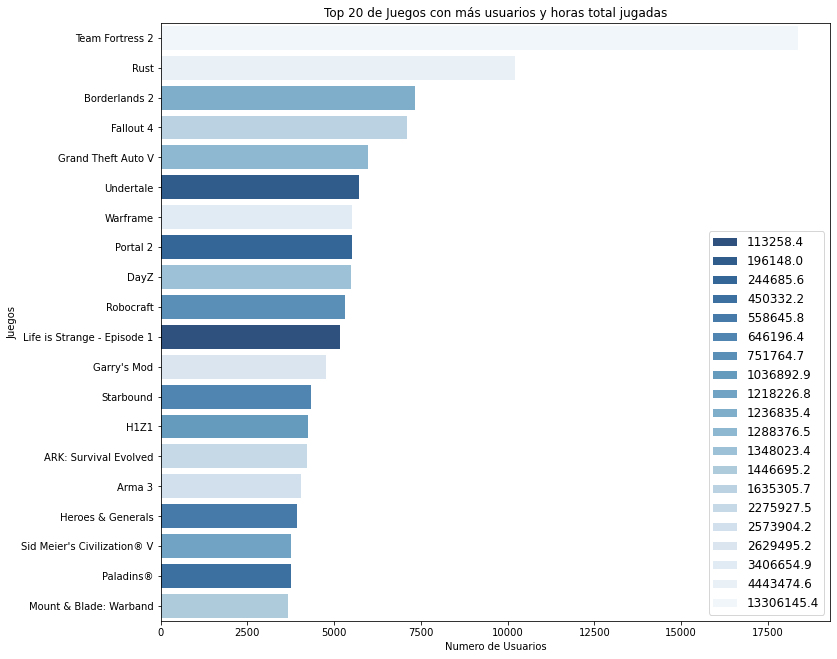

In [19]:
# Juegos con mayor número de usuarios vs horas jugadas
game_freq = df1.groupby(by='app_name').agg({'username': 'count', 'hours': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='username',ascending=False)[:20].reset_index()
#print(top20)
top20['hours']=top20['hours'].round(1)
# histogram
fig_h = 1 + 0.25 * max(1, 2*top)
fig, ax = plt.subplots(figsize=(12, fig_h))

#fig, ax = plt.figure(figsize=(20, 10))
#sns.set(font_scale = 2)
ax = sns.barplot(x='username', y='app_name', hue='hours',alpha=0.9,data=top20, palette='Blues_r',dodge=False)
ax.set(xlabel='Numero de Usuarios', ylabel='Juegos', title="Top {} de Juegos con más usuarios y horas total jugadas".format(top))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=12)
plt.show()

Se observa que no se guarda la relación supuesta, el color del gradiente  no es un degradé continua según el orden de los juegos por usuarios. Por ejemplo,  el "bordelands 2" está en el top3 según el número de usuarios, pero está en el puesto número 12 según la cantidad de horas jugadas total. A continuación vamos analizar solamente los que fueron jugados, suponemos que los que tienen una duración mayor de 1 hora fueron jugados y los que no, solamente comprados.

In [20]:
# Los comprados que consideramos que no se han jugado, tiempo menor o = a 1 hora
df1[df1['hours']<=1].shape[0]

79974

In [21]:
# Los comprados y jugados, cuyo tiempo es mayor a una hora.
df1[df1['hours']>1].shape[0]

697340

Se observa que el 10,63% de los juegos solamente fueron adquiridos y no jugados

(0.0, 3000.0)

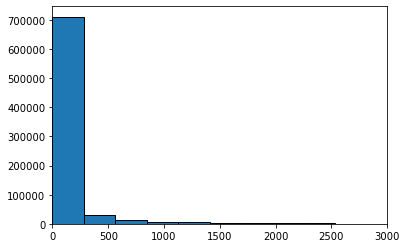

In [22]:
##Distribucion
plt.hist(df1['hours'], bins=100, alpha=1, edgecolor = 'black',  linewidth=1)
plt.xlim([0,3000]) ## limite en x, para acotar y quitar los outliers

#### Graficamos solamente a los que fueron jugados

In [23]:
#df1 = df1.copy()
#index=df1[df1['hours']==0].index
#df1.drop(index,inplace=True)
#game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
#most_played_games = game_total_hrs.sort_values(ascending=False)[:20]

<ipython-input-24-d01558092dab>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)


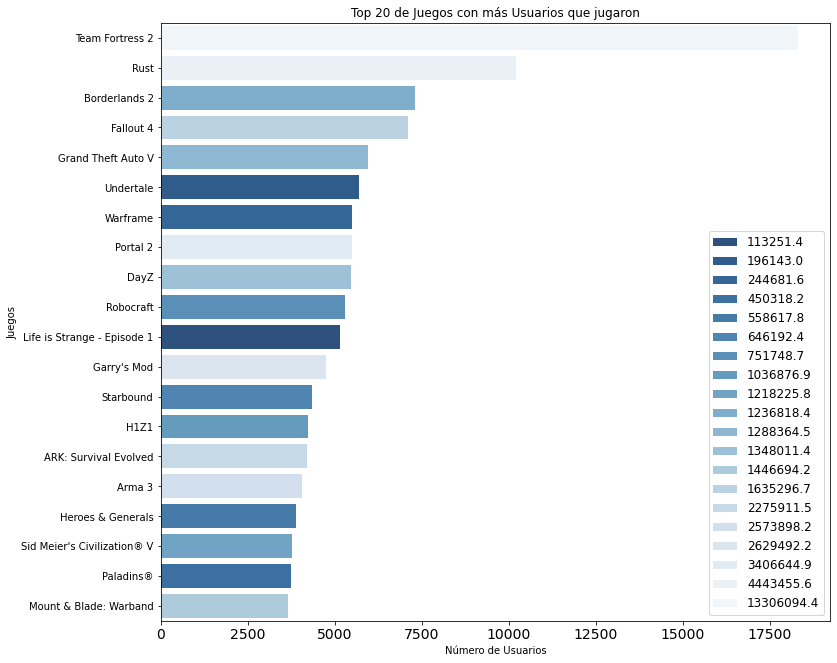

In [24]:
#Consideramos solo a los que han jugado por lo menos 1 hora
df1=df1.copy()
index=df1[df1['hours']==1].index
df1.drop(index,inplace=True)
game_total_hrs = df1.groupby(by='app_name')['hours'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:20]
# Juegos con el mayor número de usuarios
game_freq = df1.groupby(by='app_name').agg({'username': 'count', 'hours': 'sum'}).reset_index()
top20 = game_freq.sort_values(by='username',ascending=False)[:20].reset_index()
top20['hours']=top20['hours'].round(1)

fig_h = 1 + 0.25 * max(1, 2*top)
fig, axes = plt.subplots(figsize=(12, fig_h))

#plt.figure(figsize=(20, 8))
#axes = sns.set(font_scale = 2)
axes = sns.barplot(x='username', y='app_name', hue='hours',alpha=0.9,data=top20, palette='Blues_r',dodge=False)
axes.set(xlabel='Número de Usuarios', ylabel='Juegos', title='Top {} de Juegos con más Usuarios que jugaron'.format(top))
#axes.set_xticklabels(ax.get_xticklabels(), rotation=90)
axes.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
axes.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
axes.xaxis.set_tick_params(labelsize=14)
axes.legend(fontsize=12)
plt.show()

#### Número total de horas y número de usuarios por juego

In [25]:
# Total de número de horas y total de número de usuarios por juego
#user_count = df_data_users.loc[df_data_users[col_play] == 1]. \
#        groupby(col_game)[col_user].agg('count').sort_values(ascending=False)
user_count = df1.groupby('app_name')['username'].agg('count').sort_values(ascending=False) 
# hours_played = df_data_users.loc[df_data_users[col_play] == 1]. \
#        groupby(col_game)[col_hour].agg(np.sum).sort_values(ascending=False)
hours_played = df1.groupby('app_name')['hours'].agg(np.sum).sort_values(ascending=False) 

In [26]:
# Creamos el dataframe con los más jugados con el total de horas y total de usuarios por juego    
nb_games=20
df_top_hours_played = pd.DataFrame({'app_name': hours_played.index,
                                        'hours_played': hours_played.values,
                                        'user_count': user_count.values})[0:nb_games]

In [27]:
df_top_hours_played

,app_name,hours_played,user_count
0,Team Fortress 2,13306094.4,18322
1,Rust,4443455.6,10202
2,Warframe,3406644.9,7304
3,Garry's Mod,2629492.2,7104
4,Arma 3,2573898.2,5964
5,ARK: Survival Evolved,2275911.5,5705
6,Fallout 4,1635296.7,5514
7,Mount & Blade: Warband,1446694.2,5508
8,Counter-Strike: Source,1417293.9,5484
9,DayZ,1348011.4,5285


In [28]:
# Get column names from csv.
col_names = df1.columns
col_names

Index(['product_id', 'username', 'app_name', 'price', 'hours'], dtype='object')

In [29]:
# Mask criteria for box plot.
#mask_criteria = df1[col_game].isin(df_top_hours_played['game_name'])
df_box_plot = df1[['hours', 'app_name']]

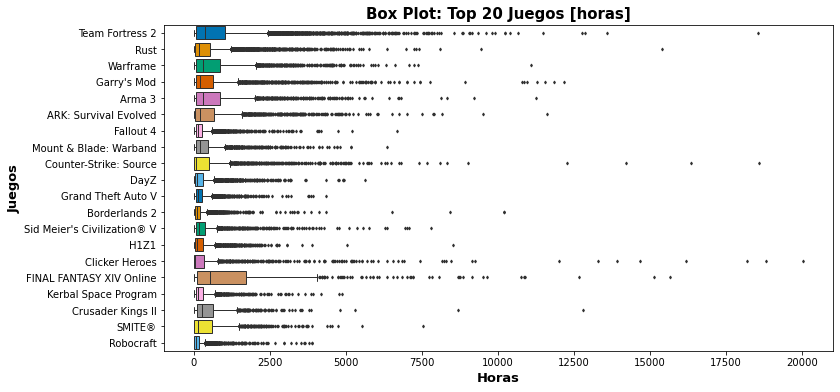

In [30]:
# Creación de box-plot.
fig_h = 1 + 0.25 * max(1, nb_games)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x='hours', y='app_name', data=df_box_plot,
                 order=df_top_hours_played['app_name'].to_list(),
                 palette="colorblind",
                 saturation=1,
                 linewidth=1,
                 fliersize=2)
plt.title('Box Plot: Top {} Juegos [horas]'.format(nb_games),fontsize=15, fontweight='heavy')
plt.xlabel('Horas', fontsize=13, fontweight='demi')
plt.ylabel('Juegos', fontsize=13, fontweight='demi')
plt.show()

In [31]:
df_box_plot.describe()

,hours
count,771527.000000
mean,112.596551
std,391.334996
min,0.000000
25%,4.100000
50%,15.600000
75%,60.300000
max,28164.000000


Para entender mejor la información de los usuarios y sus hábitos de juego, el boxplot anterior muestra el top 20 de los juegos más jugados, basado en el total de horas jugadas.

Se observa, que la distribución de la información de cada juego no es simetrica. Mirando más en detalle, el 75% de los puntos de cada juego se encuentra en el rango de miles de horas de juego, exponiendo los outliers. Por ejemplo, Team Fortress 2, un usuario jugó más de  18000 horas, o el Juego Clicker Heroes, hay un usuario jugó más de 20000 horas.

### Split Dataset

#### Split Dataset para ajustar datos

In [32]:
from pandas import read_csv
import pathlib

# Get data from CSV
dataUsers = pd.read_csv('data/mergeado.csv')
dataGames = pd.read_csv('data/data_games.csv')

# get 10% of random elements (combination user-game) for test dataset
pruebaUsers = dataUsers.sample(frac=0.1, replace=False)

# get the remaining elements for training dataset
pruebaGames = dataGames.sample(frac=0.1, replace=False)

if True:
    pruebaUsers.to_csv('data/pruebaUsers.csv', index= False)
    pruebaGames.to_csv('data/pruebaGames.csv', index= False)

In [33]:
### Cargamos los dataset spliteados, solamente usar para ajustar
pruebaUsers = pd.read_csv('data/pruebaUsers.csv')
pruebaGames = pd.read_csv('data/pruebaGames.csv')

In [34]:
print("pruebaUsers {} y pruebaGames {}".format(pruebaUsers.shape[0],pruebaGames.shape[0]))

pruebaUsers 77995 y pruebaGames 3214


#### Train Test Split

In [35]:
from pandas import read_csv
import pathlib

# Get data from CSV
dataUsers = pd.read_csv('data/mergeado.csv')

# get 20% of random elements (combination user-game) for test dataset
testUsers = dataUsers.sample(frac=0.2, replace=False)

# get the remaining elements for training dataset
trainUsers = dataUsers[~dataUsers.isin(testUsers)].dropna()

# output csv
#testUsers.to_csv(pathlib.Path(r'../data/model_data/steam_user_test.csv'), index=False)
#trainUsers.to_csv(pathlib.Path(r'../data/model_data/steam_user_train.csv'), index=False)

if True:
    testUsers.to_csv('data/testUsers.csv', index= False)
    trainUsers.to_csv('data/trainUsers.csv', index= False)

In [36]:
### Cargamos los dataset spliteados, para usar en el modelo
testUsers = pd.read_csv('data/testUsers.csv')
trainUsers = pd.read_csv('data/trainUsers.csv')

In [37]:
print("testUsers {} y trainUsers {}".format(testUsers.shape[0],trainUsers.shape[0]))

testUsers 155990 y trainUsers 612467


In [38]:
cnt_de_juegos = df1['product_id'].unique().size
cnt_usuarios = df1['username'].unique().size
print("El dataset tiene {} juegos y {} usuarios".format(cnt_de_juegos,cnt_usuarios))

El dataset tiene 12611 juegos y 537367 usuarios


#### Removemos los Outliers

In [139]:
### Filtrar outliers por juego
## Funcion para obtener filtrar los outliers, pasando el dataframe y la columna
#df_new=[]
#result_total = pd.DataFrame(columns=['A','B','C','D','E','F','G'])
#result_total = pd.DataFrame(columns=[df1.columns])
df_new = pd.DataFrame()

def remove_outlier(df_in, col_name,nombre):
    '''
    Dado un dataframe (df_in) devuelve el mismo pero
    filtrado por los límites superiores e inferiores
    según el críterio de los rangos intercuartilicos * 1.5.
    
    Arguments:
    df_in -- dataframe a filtrar
    col_name -- columna por la cual se va a filtrar los datos, valores discretos
    tipo -- tipo de propiedad para filtrar el dataset
    Returns:
    df_out -- dataframe filtrado por tipo de propiedad y límites usando los rango intercuartilicos
    '''
    #dataframe con solo un tipo de propiedad
    #df_in_type = df_in[df_in.property_type==tipo]    
    df_in_type = df_in[df_in.app_name==nombre] 
    q1 = df_in_type[col_name].quantile(0.25)
    q3 = df_in_type[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    limit_low  = q1-1.5*iqr
    limit_high = q3+1.5*iqr
    df_out = df_in_type.loc[(df_in_type[col_name] > limit_low) & (df_in_type[col_name] < limit_high)]
    #df_sin_outliers = df_new.append(df_out,ignore_index=True)
    #df_sin_outliers.append(df_out)
    return df_out

In [140]:
#def show_work_status(singleCount, totalCount, currentCount):
#    currentCount+=singleCount
#    percentage=1.*currentCount/totalCount*100
#    status='>'*int(percentage/2)+'-'*(50-int(percentage/2))
#    if percentage % 3:
#        sys.stdout.write('\rStatus:[{0}]{1:.2f}%'.format(status,percentage))
#        sys.stdout.flush()
#    if percentage>=100: print('\n')

In [141]:
## cantidad de juegos 12604
nom_juegos = df1['app_name'].unique()
print("Cantidad de Juegos",nom_juegos.shape[0])

Cantidad de Juegos 12604


In [142]:
df1.shape

(774164, 5)

In [143]:
df_sin_outliers = remove_outlier(df1,'hours','Team Fortress 2')
df_sin_outliers.shape

(17272, 5)

In [144]:
df_sin_outliers = remove_outlier(df1,'hours','Rust')
df_sin_outliers.shape

(9231, 5)

In [145]:
df_sin_outliers = remove_outlier(df1,'hours','Warframe')
df_sin_outliers.shape

(5148, 5)

In [146]:
#nom_juegos = df1['app_name'].unique()[:3]
nom_juegos = ['Team Fortress 2','Rust','Warframe']
nom_juegos

['Team Fortress 2', 'Rust', 'Warframe']

In [4]:
#df_out_list

In [5]:
# Filtramos los outliers con  la regla de 3sigmas
df_sin_outliers = []
total_count = 0
#current_count=0

for i in tqdm(range(nom_juegos)):
#for nombre in nom_juegos:
    print(nombre)
    total_count = total_count+1
    df_out = remove_outlier(df1,'hours',nombre)
    print(df_out.shape)
    df_out_list = df_out.values.tolist()
    df_out_list
    #show_work_status(1,total_count,current_count)
    #current_count+=1
    #df_sin_outliers = df_sin_outliers.append(df_out,ignore_index=True)
    #df_sin_outliers.append(df_out)
    #df_sin_outliers.append(df_out_list)
    #print(df_sin_outliers.shape)
#df_sin_outliers.shape
#df_sin_outliers = pd.DataFrame(df_sin_outliers)
#df_sin_outliers
#df_out_list

NameError: name 'nom_juegos' is not defined

In [165]:
df_out

,product_id,username,app_name,price,hours
493141,230410,@tack,Warframe,Free to Play,5.0
493142,230410,FilmFlix,Warframe,Free to Play,28.8
493143,230410,Khancer,Warframe,Free to Play,569.8
493144,230410,American Boot,Warframe,Free to Play,190.8
493145,230410,BLaDe™,Warframe,Free to Play,55.8
...,...,...,...,...,...
498654,230410,Just a Painting,Warframe,Free to Play,72.5
498655,230410,Rezz,Warframe,Free to Play,18.3
498656,230410,Rezz,Warframe,Free to Play,18.3
498657,230410,Euisroman,Warframe,Free to Play,62.0


#### Graficamos luego de quitar los outliers

In [394]:
# Mask criteria for box plot.
#mask_criteria = df1[col_game].isin(df_top_hours_played['game_name'])
df_box_plot = df_sin_outliers[['hours', 'app_name']]

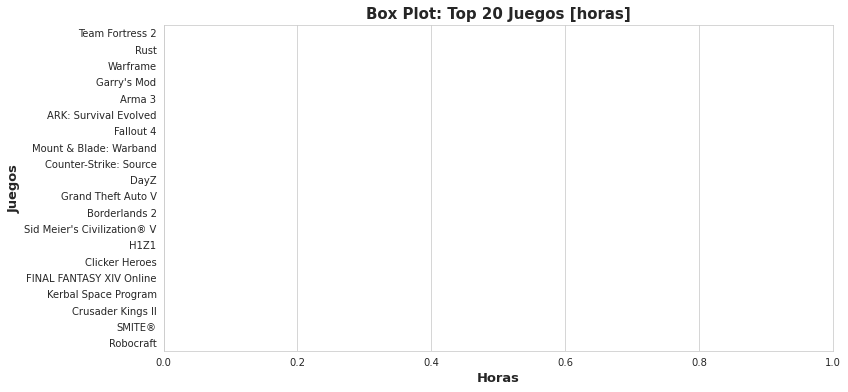

In [395]:
# Creación de box-plot.
nb_games = 20
fig_h = 1 + 0.25 * max(1, nb_games)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x='hours', y='app_name', data=df_box_plot,
                 order=df_top_hours_played['app_name'].to_list(),
                 palette="colorblind",
                 saturation=1,
                 linewidth=1,
                 fliersize=2)
plt.title('Box Plot: Top {} Juegos [horas]'.format(nb_games),fontsize=15, fontweight='heavy')
plt.xlabel('Horas', fontsize=13, fontweight='demi')
plt.ylabel('Juegos', fontsize=13, fontweight='demi')
plt.show()

In [397]:
### comprobamos el tamaño del dataset
df_sin_outliers.shape

(347, 5)

In [398]:
cnt_de_juegos = df_sin_outliers['product_id'].unique().size
cnt_usuarios = df_sin_outliers['username'].unique().size
print("El dataset tiene {} juegos y {} usuarios".format(cnt_de_juegos,cnt_usuarios))

El dataset tiene 1 juegos y 346 usuarios


In [ ]:
df_out['app_name'].unique()

In [46]:
if True:
    df_out.to_csv('data/df_out.csv', index= False)

#### Cargamos el Dataset, que ya contiene un merge con las reviews y games

In [3]:
df = pd.read_csv('data/df_out.csv')
df.head(2)

,product_id,username,hours,products,app_name,price,genres,tags,specs
0,725280,Chaos Syren,0.1,41.0,Psi Project,2.99,"['Action', 'Adventure', 'Indie', 'Simulation']","['Action', 'Adventure', 'Indie', 'Simulation']","['Single-player', 'Steam Trading Cards']"
1,725280,freakfantom,0.1,1706.0,Psi Project,2.99,"['Action', 'Adventure', 'Indie', 'Simulation']","['Action', 'Adventure', 'Indie', 'Simulation']","['Single-player', 'Steam Trading Cards']"


,product_id,username,app_name,price,hours


### Ingenieria de Features
Creacion del rating a partir de las horas Jugadas

In [53]:
df = pd.read_csv('data/mergeado.csv')
data_games = pd.read_csv('data/data_games.csv')
#df.head(2)

In [54]:
## Tamaño del dataset
df.shape

(779951, 9)

In [55]:
df1 = df[['product_id','username','app_name','price','hours']]
df1

,product_id,username,app_name,price,hours
0,725280,Chaos Syren,Psi Project,2.99,0.1
1,725280,freakfantom,Psi Project,2.99,0.1
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2
...,...,...,...,...,...
779946,518790,rt974,theHunter: Call of the Wild™,29.99,9.4
779947,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8
779948,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4
779949,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9


In [56]:
#Asumimos score inicial 0
#df1.reset_index()
df1['score'] = 0

<ipython-input-56-d4a6635fdde4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['score'] = 0


In [57]:
#df1[df1['username'] == 'Alex' ]
#df1.shape

In [58]:
df_copy = df1.copy()
#df1.username.value_counts()

In [59]:
df1 = df_copy.copy()

In [60]:
games_median = df1.groupby('app_name')['hours'].agg('median').sort_values(ascending=False)

In [61]:
df1.groupby(by='app_name').agg({'username': 'count' ,'hours': 'median'}).reset_index()

,app_name,username,hours
0,! That Bastard Is Trying To Steal Our Gold !,6,4.65
1,"""Glow Ball"" - The billiard puzzle game",5,3.10
2,"""TWO DRAW""",1,0.10
3,#monstercakes,12,15.95
4,$1 Ride,19,1.70
...,...,...,...
12653,軒轅劍外傳穹之扉(The Gate of Firmament),13,11.70
12654,鸿源战纪 - Tales of Hongyuan,1,36.90
12655,龙魂时刻,8,0.40
12656,＜/reality＞,1,7.90


In [62]:
## Juegos que no tienen horas jugadas
games_median.isnull().sum()

45

In [63]:
games_median.fillna(0, inplace=True)

In [64]:
# Creamos el dataframe con los más jugados con el total de horas y total de usuarios por juego    
#nb_games=20
#df_games_median = pd.DataFrame({'app_name': games_median.index,
#                                        'median_hours_played': games_median.values})[0:nb_games]
df_games_median = pd.DataFrame({'app_name': games_median.index,
                                        'median_hours_played': games_median.values})
df_games_median

,app_name,median_hours_played
0,Audials One Suite 2016,1476.5
1,Super Goo Goo,1392.6
2,Let's Explore the Jungle (Junior Field Trips),999.0
3,3DF Zephyr Lite Steam Edition,916.3
4,DJ Streamer,727.1
...,...,...
12653,X Rebirth: Home of Light,0.0
12654,Zombie Driver HD Apocalypse Pack,0.0
12655,Zombie Driver HD Tropical Race Rage,0.0
12656,Zup! 2 - DLC,0.0


In [65]:
# Agregamos el nombre del juego haciendo un marge y tomando el nombre del juedo del dataset data_games
df_games_median = pd.merge(df_games_median,data_games, left_on = "app_name", right_on = "app_name")
df_games_median.drop(['genres','publisher','title','url','release_date','tags','discount_price','reviews_url','specs','price','early_access','developer','sentiment','metascore'], axis=1, inplace=True)
#df_games_median.head()

In [66]:
# Eliminamos los nulos y reseteamos el indice
df_games_median.dropna(inplace=True)
df_games_median.id.isnull().sum()
df_games_median.id = df_games_median.id.astype(int)
df_games_median.reset_index(drop=True)

,app_name,median_hours_played,id
0,Audials One Suite 2016,1476.5,405470
1,Super Goo Goo,1392.6,363900
2,Let's Explore the Jungle (Junior Field Trips),999.0,363070
3,3DF Zephyr Lite Steam Edition,916.3,438450
4,DJ Streamer,727.1,497150
...,...,...,...
12676,X Rebirth: Home of Light,0.0,415800
12677,Zombie Driver HD Apocalypse Pack,0.0,220823
12678,Zombie Driver HD Tropical Race Rage,0.0,220824
12679,Zup! 2 - DLC,0.0,569410


In [67]:
df_games_median.shape

(12681, 3)

In [68]:
df_games_median.head()

,app_name,median_hours_played,id
0,Audials One Suite 2016,1476.5,405470
1,Super Goo Goo,1392.6,363900
2,Let's Explore the Jungle (Junior Field Trips),999.0,363070
3,3DF Zephyr Lite Steam Edition,916.3,438450
4,DJ Streamer,727.1,497150


In [69]:
#df_games_median[df_games_median.id == 238750 ]

In [70]:
#nombres de juegos y su cantidad
nom_juegos = df1['app_name'].unique()
nom_juegos.shape

(12658,)

In [71]:
# Prueba para buscar valores
#df1.product_id[i]
product_id = 725280
#df_games_median[df_games_median[df_games_median.id == df1.product_id[1]]]
print(df_games_median.id[0])
h= df1.hours[0]
print(h)
float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played)

405470
0.1


0.1

In [72]:
product_id = 541570
#df1.reset_index(inplace=True)
i=1
print(float(df1.hours[i]))
print(float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played))
print(float(df1.hours[i]) > float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played))
#df1.loc[float(df1.hours[i]) > float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played), 'rt']  = 1
#df1.hours[i]
#float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values)
df1.loc[(df1.hours[i]) > float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played), 'score']  = 1

#df.iloc[0, df.columns.get_loc('col2')] = 100
df1

0.1
1.7
False


,product_id,username,app_name,price,hours,score
0,725280,Chaos Syren,Psi Project,2.99,0.1,1
1,725280,freakfantom,Psi Project,2.99,0.1,0
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2,0
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,0
...,...,...,...,...,...,...
779947,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8,0
779948,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4,0
779949,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9,0
779950,518790,Parad0x +x,theHunter: Call of the Wild™,29.99,1.3,0


#### Creación del rating
Se crea un score, donde si el tiempo jugado por un usuario de un juego X supera el tiempo de la mediana de ese juego se lo califica como positivo, es decir con el valor 1, en caso contrario el score será de "0"

In [73]:
numero = 0
##conda install tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm

for i in tqdm(range(1,df1.shape[0]-1)):
    i+= 1
    singleCount=i
    currentCount=i
#   print("XXXXXXXXXXXXXXXXXXXX")
#   print("i",i)
#   product_id = df1.product_id[i]
#   print("product_id: ",product_id)
#   print("hours en df1: ", df1.hours[i])
#   print("median_hours_played: ",float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played))
    
#   print("hours >= median", float(df1.hours[i]) >= float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values) )
#   print("hours < median", float(df1.hours[i]) < float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values))
    
    x = float(df1.hours[i]) >= float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values)
#   print("salida de x:",x)

    
    if x is True:
        #print("x is True")
        #df1.loc[float(df1.hours[i]) >= float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values), 'score']  = 1
        df1.loc[i,'score']  = 1
        #print("ratting", df1.ratting.loc[i])
    elif x is False:
        #print("x is False")
        #df1.loc[float(df1.hours[i]) < float(df_games_median.loc[df_games_median.id == product_id ].median_hours_played.values), 'score']  = 0
        df1.loc[i, 'score']  = 0
        #print("ratting", df1.ratting.loc[i])
#

#### Limitador para probar y cortar antes
#    numero += 1
#    #print("numero",numero)
#    if numero > 5:
#        #print(i)
#        df1.head()
#        break

df1

## Guardamos el dataset con los scores
if True:
    df1.to_csv('data/df_scores.csv', index= False)


  0%|          | 0/779950 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [74]:
### Cantidad de scores positivos (1) y negativos (0)
df1.score.value_counts()

0    779888
1        64
Name: score, dtype: int64

#### Guardamos el dataframe con el rating

In [28]:
df1.to_csv('data/df_scores2.csv', index= False)

NameError: name 'df1' is not defined

In [29]:
df1.head()

NameError: name 'df1' is not defined

In [29]:
df1.shape

(779952, 6)

<AxesSubplot:>

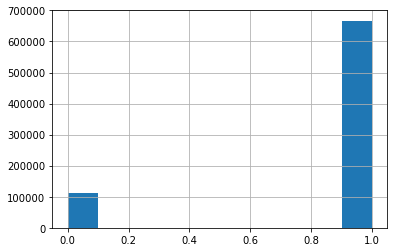

In [6]:
#Cargamos dataset
df = pd.read_csv('data/df_scores2.csv')
df.score.hist()

### **Encode**

Encodeamos el nombre del juego así tener una variable numerica y con números consecutivos. También encodeamos el nombre de usuario ya que los ID proporcionados la mayoria de los datos son nulos, con lo cual al cargar el dataset se descartó esa columna para luego crear un identificador manualmente.

https://towardsdatascience.com/encoding-categorical-features-21a2651a065c


Hacer un rectangulo, tomar esos datos y pasarlos al modelo.

Usar laberencoder para encodear los nombres de los usuarios y también el product id, así tener una variable numérica continua y poder filtrar con where y obtener el rectángulo.


In [30]:
#Cargamos dataset
df1 = pd.read_csv('data/df_scores2.csv')

In [31]:
df = df1[['product_id','username','app_name','score']]
df.head()

,product_id,username,app_name,score
0,725280,Chaos Syren,Psi Project,1
1,725280,freakfantom,Psi Project,0
2,328100,Ariman1,Gunspell - Steam Edition,1
3,328100,dll3z,Gunspell - Steam Edition,0
4,328100,Nyazicat,Gunspell - Steam Edition,1


In [32]:
df.dtypes

product_id     int64
username      object
app_name      object
score          int64
dtype: object

LabelEncoder

In [33]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object

In [34]:
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols

['username', 'app_name']

In [35]:
# LabelEncoder converts each class under specified feature to a numerical value. Let’s go through the steps to see how to do it.
#Instantiate a LabelEncoder object:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

In [36]:
df = df.copy()
#Apply LabelEncoder on each of the categorical columns:
# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [37]:
df = df[categorical_cols]
#hacer rename columnas
df.rename(columns={'username': 'user_num', 'app_name': 'app_num'}, inplace=True)


In [38]:
df

,user_num,app_num
0,62543,8117
1,434602,8117
2,26902,4762
3,425512,4762
4,247073,4762
...,...,...
779947,115945,12621
779948,137066,12621
779949,459107,12621
779950,257136,12621


Note that the output of LabelEncoder is still a dataframe. The results is shown as following:

In [39]:
result = pd.concat([df, df1], axis=1, join="inner")

In [40]:
result

,user_num,app_num,product_id,username,app_name,price,hours,score
0,62543,8117,725280,Chaos Syren,Psi Project,2.99,0.1,1
1,434602,8117,725280,freakfantom,Psi Project,2.99,0.1,0
2,26902,4762,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2,1
3,425512,4762,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
4,247073,4762,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,1
...,...,...,...,...,...,...,...,...
779947,115945,12621,518790,Fallenglory,theHunter: Call of the Wild™,29.99,35.8,1
779948,137066,12621,518790,GooseMan,theHunter: Call of the Wild™,29.99,32.4,1
779949,459107,12621,518790,lazyboy82,theHunter: Call of the Wild™,29.99,96.9,1
779950,257136,12621,518790,Parad0x +x,theHunter: Call of the Wild™,29.99,1.3,0


In [41]:
result = result[['user_num','app_num','score']]
result.head(5)

,user_num,app_num,score
0,62543,8117,1
1,434602,8117,0
2,26902,4762,1
3,425512,4762,0
4,247073,4762,1


Ordenamos el datast por usuario y juego

In [42]:
result = result.copy()
result.sort_values(['user_num', 'app_num'], ascending=[True, True], inplace=True)
#result.sort_values(['user_num'], ascending=True, inplace=True)

result.head()

,user_num,app_num,score
698212,0,8922,1
353885,1,802,1
458745,1,11778,1
693974,2,1552,1
636613,3,4681,1


In [43]:
result.shape

(779952, 3)

In [44]:
result.user_num.nunique()

540339

In [45]:
result.user_num.isnull().sum()

0

In [46]:
result.app_num.isnull().sum()

0

In [47]:
result.dtypes

user_num    int64
app_num     int64
score       int64
dtype: object

In [48]:
(result['user_num'] < 1000).sum()

1273

In [49]:
result[result['user_num'] < 1000].nunique()

user_num    1000
app_num      672
score          2
dtype: int64

In [50]:
(result['app_num'] < 1000).sum()

52479

Creamos filtro para obtener un rectágulo de la matriz, así tener de los usuarios seleccionados todas sus clasificaciones.

In [51]:
filter1 = result['user_num'] < 10000
filter2 = result['app_num'] < 1000

In [52]:
# filtering data on basis of both filters
dfx =  result.where(filter1 & filter2, inplace = False)

In [53]:
dfx.dropna(inplace=True)
dfx.reset_index(drop=True, inplace=True)

In [54]:
dfx

,user_num,app_num,score
0,1.0,802.0,1.0
1,9.0,798.0,1.0
2,45.0,590.0,1.0
3,53.0,669.0,1.0
4,57.0,283.0,1.0
...,...,...,...
1012,9930.0,779.0,0.0
1013,9932.0,779.0,0.0
1014,9944.0,238.0,0.0
1015,9950.0,870.0,1.0


Guardamos en un csv, el rectángulo.

In [55]:
dfx.to_csv('data/df_rating_encoded_rectangulo_1.csv', index= False)

In [39]:
################################################################################### borrar este filtro, no lo voy a usar

In [266]:
result2 = pd.concat([df, df1], axis=1, join="inner")
result2 = result2[['user_num','app_num','score']]
result2.head(5)

,user_num,app_num,score
0,62543,8117,1
1,434602,8117,0
2,26902,4762,1
3,425512,4762,0
4,247073,4762,1


In [267]:
result2 = result2.copy()
result2.sort_values(['user_num'], ascending=True, inplace=True)
result2.head()

,user_num,app_num,score
698212,0,8922,1
458745,1,11778,1
353885,1,802,1
693974,2,1552,1
636613,3,4681,1


In [276]:
(result2['user_num'] < 1000).sum()

1273

In [278]:
result2[result2['user_num'] < 1000].nunique()

user_num    1000
app_num      672
score          2
dtype: int64

In [281]:
filter1 = result['user_num'] < 10000
filter2 = result['app_num'] < 1000

In [282]:
# filtering data on basis of both filters
dfx2 =  result2.where(filter1 & filter2, inplace = False)

In [283]:
dfx2.dropna(inplace=True)
dfx2.reset_index(drop=True, inplace=True)

In [284]:
dfx2

,user_num,app_num,score
0,1.0,802.0,1.0
1,9.0,798.0,1.0
2,45.0,590.0,1.0
3,53.0,669.0,1.0
4,57.0,283.0,1.0
...,...,...,...
1012,9930.0,779.0,0.0
1013,9932.0,779.0,0.0
1014,9944.0,238.0,0.0
1015,9950.0,870.0,1.0


In [288]:
dfx2.to_csv('data/df_rating_encoded_rectangulo_2.csv', index= False)

In [102]:
#result.to_csv('data/df_rating_encoded.csv', index= False)

In [60]:
data = dfx.groupby('user_num')['app_num'].count().clip(upper=10)


<AxesSubplot:>

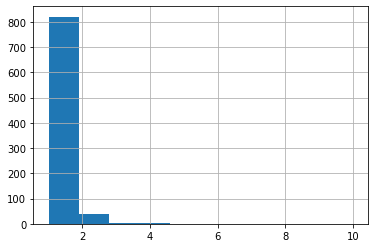

In [61]:
data.hist()

La mayoria tiene 1 calificación, muy pocos 2.

### **Implementación de Sistemas de Recomendación**

Objetivo:

Deacuerdo a la populariad del juego, similiritadad de la descripciónn del juego, la calidad del juego, y según las preferencias de los jugadores se le recomendaría un juego.

- Parte 1: Popularity-based recommendation System

#### **1) Sistema de recomendación Basado en Popularidad**

Para los nuevo usuarios de la plataforma de Steam, no conocemos nada, la forma más eficiente para esos usuarios de hacerles conocer de la plataforma es de ofrecerles los juegos más populares según los usuarios previos. Además, estos juegos no tienen limitación de tiempo. Son los juegos juegos más populares desde el tiempo de su aparición en la plataforma.

1. Primero necesitamos extraer 'product_id','username','app_name','price', luego extraer la información del top 100 de los juegos.
2. Luego ordenamos los juegos en orden descendente acuerdo al número de propietarios (Es decir, que el juego con más propietarios, es el juego más popular)


Probamos con pocos datos:

In [159]:
#df = pd.read_csv('data/pruebaUsers.csv', nrows=10000)
#df = pd.read_csv('data/pruebaUsers.csv')
df = pd.read_csv('data/mergeado.csv')


df.head(2)

,product_id,username,hours,products,app_name,price,genres,tags,specs
0,725280,Chaos Syren,0.1,41.0,Psi Project,2.99,"['Action', 'Adventure', 'Indie', 'Simulation']","['Action', 'Adventure', 'Indie', 'Simulation']","['Single-player', 'Steam Trading Cards']"
1,725280,freakfantom,0.1,1706.0,Psi Project,2.99,"['Action', 'Adventure', 'Indie', 'Simulation']","['Action', 'Adventure', 'Indie', 'Simulation']","['Single-player', 'Steam Trading Cards']"


In [160]:
df1 = df[['product_id','username','app_name','price','hours']]

In [161]:
#data_games = pd.read_csv('data/pruebaGames.csv', nrows=1000)

In [162]:
df1.head()

,product_id,username,app_name,price,hours
0,725280,Chaos Syren,Psi Project,2.99,0.1
1,725280,freakfantom,Psi Project,2.99,0.1
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2


#### Juegos más populares 
A continuación se muestra el ranking de los juegos más populares en la plataforma Steam.

In [403]:
# relizamos conteno por nombre del juego y luego ordenamos de manera descendente
df_top = df1.app_name.value_counts().sort_values(ascending = False)

df_top = pd.DataFrame(df_top)
df_top['top_game'] = df_top.index
df_top.rename({'app_name': 'cnt'}, axis=1, inplace=True)
df_top.reset_index(drop=True, inplace=True)
df_top = df_top[['top_game','cnt']].sort_values(['cnt'], ascending=False)
df_top.head(10)

,top_game,cnt
0,Team Fortress 2,1807
1,Rust,1050
2,Borderlands 2,729
3,Fallout 4,701
4,Undertale,584
5,Portal 2,581
6,DayZ,567
7,Grand Theft Auto V,558
8,Robocraft,554
9,Warframe,544


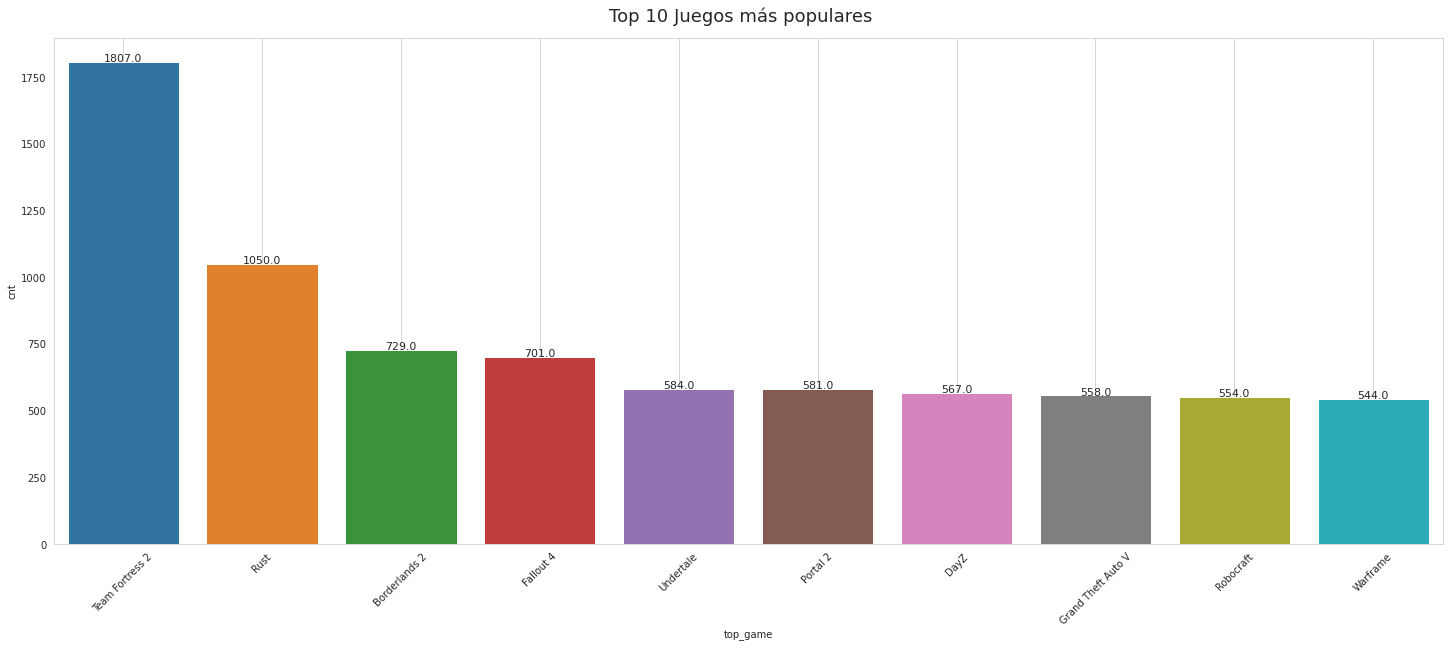

In [404]:
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,1, figsize=(20, 8))
fig.suptitle('Top 10 Juegos más populares', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=1.0)

# GRacount 0
#sns.countplot(data = df_top, x = "top_game", orient='v', ax=axes, order = df_top['cnt'].value_counts().index)
sns.barplot(x="top_game", y="cnt", ax=axes,orient="v", data=df_top.head(10))
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
plt.sca(axes)
plt.xticks(rotation=45)
plt.grid()

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)


Es decir, a los clientes que recién ingresen a la plataforma se le recomendará los juegos más populares.

#### **2) Filtro Colaborativo**

A los usuarios se le recomiendan artículos que a personas con gustos y preferencias similares les gustaban en el pasado. En otras palabras, este método predice calificaciones desconocidas utilizando las similitudes entre los usuarios.

Usaremos la libreria `Surprise`  y  probaremos varios algoritmos para ver cual es que obtiene un menor MAE (Mean Absolute Error) y si vale la pena por tiempo de computo ya que estamos trabajando con Big Data. 

Buscar métrica para problemas de clasificación, ya que es una variable binario (0,1)


Con la biblioteca `Surprise`, compararemos los siguientes algoritmos: <br>
**Algoritmos básicos** <br>

`NormalPredictor` El algoritmo NormalPredictor predice una clasificación aleatoria basada en la distribución del conjunto de entrenamiento, que se supone que es normal. Este es uno de los algoritmos más básicos que no hace mucho trabajo. <br>
`BaselineOnly`
El algoritmo BaselineOnly predice la estimación de baseline para un usuario y elemento determinados.


**algoritmos k-NN**

`KNNBasic` : KNNBasic es un algoritmo de filtrado colaborativo básico. <br>
`KNNWithMeans`: KNNWithMeans es un algoritmo de filtrado colaborativo básico, teniendo en cuenta las valoraciones medias de cada usuario. <br>
`KNNWithZScore`: KNNWithZScore es un algoritmo de filtrado colaborativo básico que tiene en cuenta la normalización del z-score de cada usuario. <br>
`KNNBaseline`: KNNBaseline es un algoritmo de filtrado colaborativo básico que tiene en cuenta una calificación de referencia. <br>

**Algoritmos basados en la factorización de matrices**

`SVD` : El algoritmo SVD es equivalente a la factorización matricial probabilística <br>
`SVDpp`: El algoritmo SVDpp es una extensión de SVD que tiene en cuenta las calificaciones implícitas. <br>
`NMF`: NMF es un algoritmo de filtrado colaborativo basado en factorización matricial no negativa. Es muy similar con SVD. <br>
`Slope One`: SlopeOne es una implementación sencilla del algoritmo SlopeOne. <br>
`Co-clustering`:  Coclustering es un algoritmo de filtrado colaborativo basado en co-clustering. <br>

Usamos "MAE" como nuestra métrica de precisión para las predicciones.

#### Train Test Split

In [45]:
from pandas import read_csv
import pathlib

# Get data from CSV
dataUsers = pd.read_csv('data/df_scores2.csv')

# get 20% of random elements (combination user-game) for test dataset
testUsers = dataUsers.sample(frac=0.2, replace=False)

# get the remaining elements for training dataset
trainUsers = dataUsers[~dataUsers.isin(testUsers)].dropna()

# output csv
#testUsers.to_csv(pathlib.Path(r'../data/model_data/steam_user_test.csv'), index=False)
#trainUsers.to_csv(pathlib.Path(r'../data/model_data/steam_user_train.csv'), index=False)

if True:
    testUsers.to_csv('data/testUsers.csv', index= False)
    trainUsers.to_csv('data/trainUsers.csv', index= False)

In [46]:
### Cargamos los dataset spliteados, para usar en el modelo
testUsers = pd.read_csv('data/testUsers.csv')
trainUsers = pd.read_csv('data/trainUsers.csv')

In [47]:
print("testUsers {} y trainUsers {}".format(testUsers.shape[0],trainUsers.shape[0]))

testUsers 155990 y trainUsers 616487


In [48]:
cnt_de_juegos = trainUsers['product_id'].unique().size
cnt_usuarios = trainUsers['username'].unique().size
print("El dataset Tain tiene {} juegos y {} usuarios".format(cnt_de_juegos,cnt_usuarios))
#########
cnt_de_juegos = testUsers['product_id'].unique().size
cnt_usuarios = testUsers['username'].unique().size
print("El dataset Test tiene {}  juegos y {} usuarios".format(cnt_de_juegos,cnt_usuarios))
#########
cnt_de_juegos = dataUsers['product_id'].unique().size
cnt_usuarios = dataUsers['username'].unique().size
print("El dataset Todo tiene {} juegos y {} usuarios".format(cnt_de_juegos,cnt_usuarios))

El dataset Tain tiene 11870 juegos y 446803 usuarios
El dataset Test tiene 8273  juegos y 135710 usuarios
El dataset Todo tiene 12665 juegos y 540339 usuarios


,product_id,username,app_name,price,hours,score
0,725280.0,Chaos Syren,Psi Project,2.99,0.1,1.0
1,725280.0,freakfantom,Psi Project,2.99,0.1,0.0
2,328100.0,dll3z,Gunspell - Steam Edition,14.99,0.4,0.0
3,328100.0,novocain,Gunspell - Steam Edition,14.99,3.8,1.0
4,328100.0,raixel,Gunspell - Steam Edition,14.99,3.2,1.0
...,...,...,...,...,...,...
616511,518790.0,Fallenglory,theHunter: Call of the Wild™,29.99,35.8,1.0
616512,518790.0,GooseMan,theHunter: Call of the Wild™,29.99,32.4,1.0
616513,518790.0,lazyboy82,theHunter: Call of the Wild™,29.99,96.9,1.0
616514,518790.0,Parad0x +x,theHunter: Call of the Wild™,29.99,1.3,0.0


### **Surprice**

Primero vamos a probar con la pequeña matriz o rectangulo obtenido anteriormente (dfx), en donde tenemos todos los datos de un usuario en particular, es decir del usuario 1 tenemos todas la calificaciones. Esta matriz la usaremos para el modelo, es decir que tenemos que realizar el train test split y crear la funcionion de prediccion con estos datos.

Luego una vez validado el modelo con los datos anteriores pasamos a utilizar el dataset total, a este le hacemos el train test split y luego aplicamos la prediccions

In [4]:
### Surprice
## conda install -c conda-forge scikit-surprise

import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse, mae
from surprise import accuracy
from surprise.model_selection import train_test_split

1) Probamos con el dataset que obtuvimos anteriormente, que es un rectangulo de los datos donde de cada usuario obtenido tenemos todas sus calificaciones. Esto lo usuamos para reducir tiempo de procesamiento y validar nuestro modelo.

Surprise necesita un conjunto de datos, con tres variables: identificación de usuario, identificación del artículo y calificación. Esto es importante, no hay que pasar las calificaciones en un formato de matriz de calificaciones de elementos de usuario. El dataset tiene 3 columnas y el número de filas es igual al número total de calificaciones individuales. A continuación cargamos el dataset (user_num, app_num, score):

In [5]:
ratings = pd.read_csv('data/df_rating_encoded_rectangulo_1.csv')
ratings.head()

,user_num,app_num,score
0,1.0,802.0,1.0
1,9.0,798.0,1.0
2,45.0,590.0,1.0
3,53.0,669.0,1.0
4,57.0,283.0,1.0


Se crea el objeto Reade, con los siguientes atributos:
- line_format: asegurar que el orden corresponda con el del dataset
- sep: es coma, si estamos trabajando con csv
- rating_scale: is una tuple con el menor y mayor rango posible. Es importante establecer correctamente este parámetro, porque en caso contrario cierta data puede ser ignorada. Si usamos un score binario, el valor correcto es la tupla (0,1)

In [6]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

#ither way, you will need to define a Reader object for Surprise to be able to parse the file or the dataframe.
#To load a dataset from a file (e.g. a csv file), you will need the load_from_file() method:
To load a dataset from a pandas dataframe, you will need the load_from_df() method. You will also need a Reader object, but only the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings in this order. Each row thus corresponds to a given rating. This is not restrictive as you can reorder the columns of your dataframe easily.


Para importar la data, usamos el método `load_form_file`, Luego de esto ya tenemos el dataset en formato `surprise` 

In [7]:
ratings = ratings[['user_num','app_num','score']]
data = Dataset.load_from_df(ratings, reader)
#data.split(n_folds=5)

De la clase `model_selection` importamos el método `train_test_split`. Dividimos la data en `trainset` y `testset`, `test_size` está seteado al 20%. Una vez más, es un poco diferente de cómo funcionaría un modelo de clasificador / regresión, el conjunto de pruebas contiene calificaciones de usuarios / elementos seleccionados al azar, en lugar de usuarios / elementos completos. Un usuario puede tener 10 calificaciones en los datos, y 3 de ellas ahora se seleccionan al azar para el conjunto de pruebas, no para ser utilizadas para ajustar el modelo. Tiene mucho sentido no omitir por completo a ciertos usuarios.

In [8]:
trainset, testset = train_test_split(data, test_size=0.2)

El segundo enfoque es utilizar los datos completos y realizar una validación cruzada para las pruebas. En ese caso, podemos construir un objeto Trainset usando todas las calificaciones con el método build_full_trainset:

In [9]:
trainsetfull = data.build_full_trainset()

Para obtener la cantidad de elementos / usuarios usamos los métodos n_users y n_items (el mismo enfoque funciona para trainsetfull, porque son el mismo tipo de objeto):

In [10]:
print('Numero de usuarios: ', trainset.n_users, '\n')
print('Numero de items:   ', trainset.n_items, '\n')

Numero de usuarios:  707 

Numero de items:    172 



Cuando `surprise` crea un objeto `Trainset` o `Testset`, toma los `raw_id` (los que usó en el archivo que importó) y los convierte en los llamados `inner_id` (básicamente una serie de números enteros, comenzando desde 0). Es posible que deba rastrear hasta los nombres originales. Usando los elementos como ejemplo (puede hacer el mismo enfoque con los usuarios, simplemente intercambie `iid` con `uid` en el código), para obtener la lista de `inner_iids`, puede usar el método `all_items`. Para convertir de raw a ID interno, puede usar el método `to_inner_iid` y el `to_raw_iid` para volver a convertir.
Un ejemplo sobre cómo guardar una lista de ID de elementos internos y sin procesar:

In [11]:
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [12]:
trainset_raw_iids[:5]

[986.0, 283.0, 778.0, 246.0, 862.0]

In [13]:
trainset_uids = list(trainset.all_items())
uid_converter = lambda x: trainset.to_raw_uid(x)
trainset_raw_uids = list(map(uid_converter, trainset_uids))

In [14]:
trainset_raw_uids[:5]

[5886.0, 3735.0, 7549.0, 4583.0, 1079.0]

#### Creamos un Benchmark

In [23]:
benchmark = []
# Iterate over all algorithms
for algo in [SVD(), SVDpp(), SlopeOne(), NMF(n_factors=0), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    #print(algo)
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.342827,0.116102,0.004353
BaselineOnly,0.345440,0.004014,0.002979
KNNBaseline,0.346273,0.009231,0.005861
SVD,0.346415,0.051279,0.002493
CoClustering,0.356200,0.115641,0.002463
KNNWithMeans,0.356739,0.013793,0.004532
SlopeOne,0.357129,0.007834,0.003485
KNNBasic,0.362053,0.006577,0.004456
KNNWithZScore,0.364735,0.040772,0.007432


### Train and Predict
Con el algoritmo SVDpp obtuvimos el mejor RMSE, ahora vamos a entrenar y predecir con SVDpp y usar Alternating Least Squares (ALS).

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of MAE. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset.


In [24]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }

In [25]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
#algo = BaselineOnly()
predictions = algo.fit(trainset).test(testset)
accuracy.mae(predictions)

Estimating biases using als...
MAE:  0.2277


0.22769719943123856

In order to do one prediction, you can use the raw id’s, so to get the TestUser1’s (a user that has at least min_k number of other ratings in the data) estimated rating of game with id 161936, you need the predict method of your trained algorithm

In [27]:
algo.predict(uid = 'TestUser1', iid = '161936')

Prediction(uid='TestUser1', iid='161936', r_ui=None, est=0.8503937007874016, details={'was_impossible': False})

r_ui is None, because the user does not have an actual rating for that item. It is the est item that we are ultimately interested in, that is the estimated rating, in our case, we estimate the rating to be 0.87

Para el usuario 1 y el juego 802 obtengo los inner_id’s

In [33]:
# Obtengo todos los id
trainset_iids = list(trainset.all_items())
# los convierto al formato original
iid_converter = lambda x: trainset.to_raw_iid(x)
# realizo el mapeo y obtengo una lista con los valores originales
trainset_raw_iids = list(map(iid_converter, trainset_iids))
len(trainset_raw_iids)

167

to_inner_iid(riid)
Convert an item raw id to an inner id.  Es decir buscamos el inner_id’s para el item 802

In [36]:
trainset.to_inner_iid(802)

7

In [ ]:
trainset_uids = list(trainset.all_items())
uid_converter = lambda x: trainset.to_raw_uid(x)
trainset_raw_uids = list(map(uid_converter, trainset_uids))

to_inner_uid(ruid)
Convert a user raw id to an inner id.  Es decir buscamos el inner_id’s para el usuario 1

In [37]:
trainset.to_inner_uid(1)

309

Predecimos para ese usuario (1)e item (802)

In [38]:
algo.predict(uid = '1', iid = '802')

Prediction(uid='1', iid='802', r_ui=None, est=0.8503937007874016, details={'was_impossible': False})

r_ui es None, porque el usuario no tiene un rating para ese item. est, es la calificación estimada del item/usuario que nos interesa.

Sistema recomendador, sacar the top best y el top_worst, con esto puedo sacar una porción del best(80%) que sabemso que le va a gustar y tratar de sorprender al usuario introducien do valores nuevos con el de Worst, así si el usuario llega a dar un me gusta alguno de los items recomendados podemos usar eso para retroalimenar nuestro modelo

En el link está la funcion para recomendar:


https://surprise.readthedocs.io/en/stable/FAQ.html

In [30]:
# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3039  0.3169  0.3862  0.3568  0.3515  0.3431  0.0294  
MAE (testset)     0.1933  0.2113  0.2391  0.2332  0.2246  0.2203  0.0164  
Fit time          0.06    0.06    0.08    0.07    0.06    0.06    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.3039489 , 0.31686582, 0.38618248, 0.35677271, 0.35153811]),
 'test_mae': array([0.1932781 , 0.21130716, 0.23913766, 0.23324785, 0.22459379]),
 'fit_time': (0.057524919509887695,
  0.05844855308532715,
  0.07809829711914062,
  0.06719493865966797,
  0.05519533157348633),
 'test_time': (0.0015761852264404297,
  0.0024552345275878906,
  0.0012700557708740234,
  0.0019249916076660156,
  0.0018122196197509766)}

In [31]:
from surprise import BaselineOnly
cross_validate(BaselineOnly(), data, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3368  0.3019  0.3763  0.3291  0.3747  0.3438  0.0284  
MAE (testset)     0.2167  0.2087  0.2426  0.2263  0.2297  0.2248  0.0116  
Fit time          0.00    0.01    0.01    0.00    0.00    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.33682464, 0.30185643, 0.37630609, 0.32911838, 0.37472748]),
 'test_mae': array([0.21674022, 0.20871582, 0.24260243, 0.22626891, 0.22974783]),
 'fit_time': (0.002812623977661133,
  0.0075533390045166016,
  0.00998377799987793,
  0.002819061279296875,
  0.004692554473876953),
 'test_time': (0.0017664432525634766,
  0.0017070770263671875,
  0.001867532730102539,
  0.0017619132995605469,
  0.0010361671447753906)}

### Benchmarks
Here are the average RMSE, MAE and total execution time of various algorithms (with their default parameters) on a 5-fold cross-validation procedure. The folds are the same for all the algorithms. All experiments are run on a notebook with Intel Core i5 7th gen (2.5 GHz) and 8Go RAM. The code for generating these tables can be found in the benchmark example.

In [32]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.3376


0.3376417136263484

In [33]:
#Note that you can train and test an algorithm with the following one-line:
predictions = algo.fit(trainset).test(testset)

In [34]:
from surprise import KNNBasic
# Build an algorithm, and train it.
algo = KNNBasic()
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


We can now predict ratings by directly calling the predict() method. Let’s say you’re interested in user 196 and item 302 (make sure they’re in the trainset!), and you know that the true rating 

In [35]:
uid = str(45.0)  # raw user id (as in the ratings file). They are **strings**!
iid = str(590.0)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 45.0       item: 590.0      r_ui = 4.00   est = 0.84   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [ ]:
The predict() uses raw ids (please read this about raw and inner ids). As the dataset we have used has been read from a file, the raw ids are strings (even if they represent numbers).

In [36]:
uid = str(57.0)  # raw user id (as in the ratings file). They are **strings**!
iid = str(283.0)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 57.0       item: 283.0      r_ui = 4.00   est = 0.84   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [ ]:
2) Probamos con el dataset completo

In [11]:
ratings = pd.read_csv('data/df_scores2.csv')
ratings.head()

,product_id,username,app_name,price,hours,score
0,725280,Chaos Syren,Psi Project,2.99,0.1,1
1,725280,freakfantom,Psi Project,2.99,0.1,0
2,328100,Ariman1,Gunspell - Steam Edition,14.99,13.2,1
3,328100,dll3z,Gunspell - Steam Edition,14.99,0.4,0
4,328100,Nyazicat,Gunspell - Steam Edition,14.99,2.2,1


In [290]:
dfx

,user_num,app_num,score
0,1.0,802.0,1.0
1,9.0,798.0,1.0
2,45.0,590.0,1.0
3,53.0,669.0,1.0
4,57.0,283.0,1.0
...,...,...,...
1012,9930.0,779.0,0.0
1013,9932.0,779.0,0.0
1014,9944.0,238.0,0.0
1015,9950.0,870.0,1.0


In [291]:
#ratings = ratings[['product_id','app_name','score']]
ratings = dfx[['user_num','app_num','score']]

In [1]:

data = Dataset.load_from_df(ratings, reader)
#data.split(n_folds=5)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

NameError: name 'Dataset' is not defined

We get a mean Root Mean Sqaure Error of 0.8963 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [36]:
ratings[ratings['username'] == 'Ariman1']

,username,app_name,score
2,Ariman1,Gunspell - Steam Edition,1
355378,Ariman1,Stone Age Wars,0
545052,Ariman1,Green Ranch,1


username    object
app_name    object
score        int64
dtype: object

In [34]:
df1 = df[['product_id','username','app_name','price']]

In [35]:
Pop_rec = df1.groupby(['product_id'], as_index=False)['price'].count().sort_values(['price'], ascending=False)

In [36]:
Pop_rec = df1['product_id'].value_counts().head(100)
Pop_rec.head()
Pop_rec = pd.DataFrame(Pop_rec)
Pop_rec['product_top'] = Pop_rec.index
Pop_rec.rename({'product_id': 'cnt'}, axis=1, inplace=True)
Pop_rec.reset_index(drop=True, inplace=True)
Pop_rec = Pop_rec[['product_top','cnt']].sort_values(['cnt'], ascending=False)
Pop_rec.head(5)

,product_top,cnt
0,440,18373
1,252490,10221
2,49520,7321
3,377160,7113
4,271590,5976


In [37]:
#data_games[data_games.id == '440']

<AxesSubplot:xlabel='product_top', ylabel='cnt'>

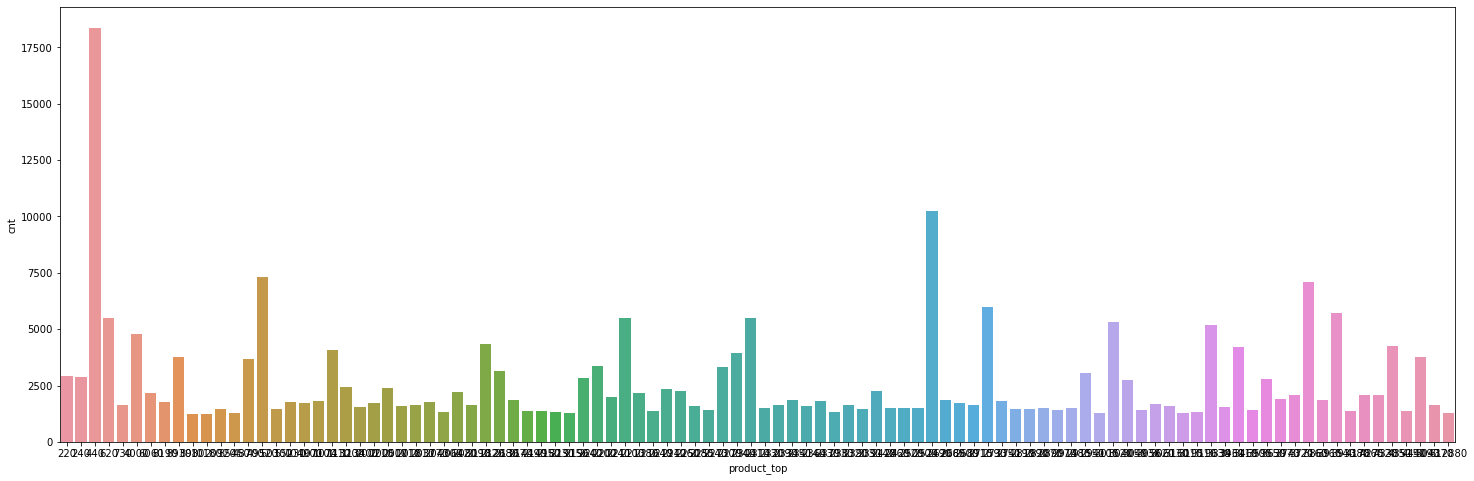

In [38]:
fig, axes = plt.subplots(1,1, figsize=(25, 8))
sns.barplot(x="product_top", y="cnt", data=Pop_rec)

In [39]:
#data_reviews_2 = data_reviews[['username','product_id']]
#data_reviews_2

In [40]:
#data_games.shape

In [41]:
#mergeado.head()

In [42]:
df[['username','product_id','title']]

KeyError: "['title'] not in index"

#### Pairplot para ver la distribución de todas las variables

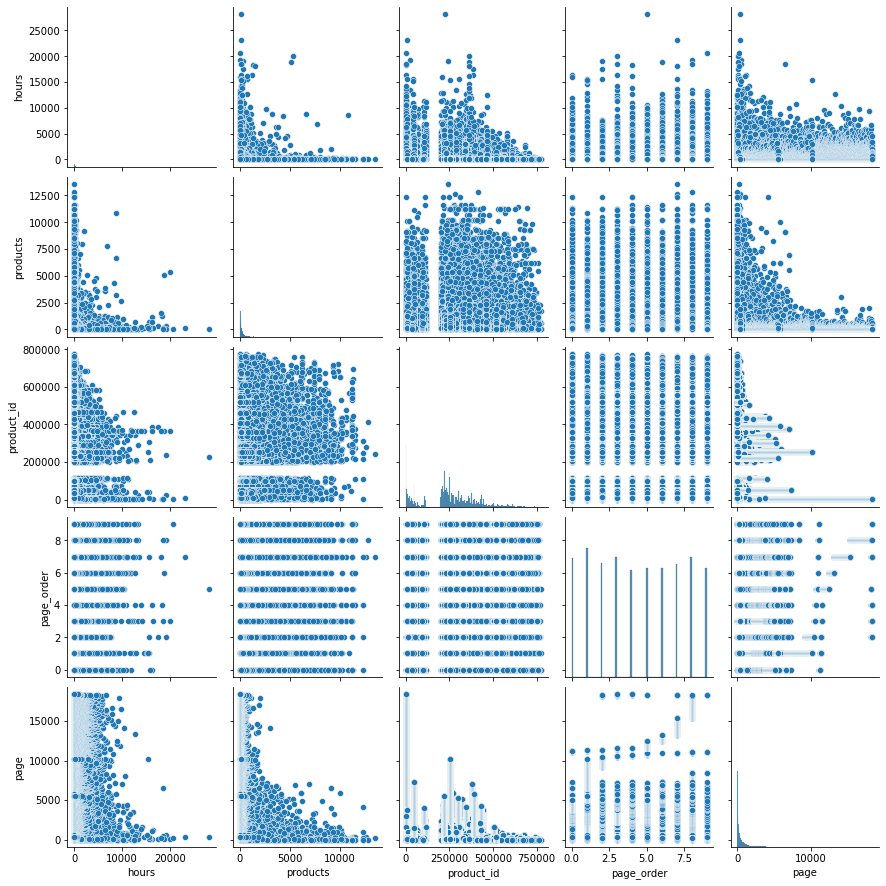

In [7]:
### vemos las ditribuciones de las variables
import seaborn as sns, numpy as np
#ax = sns.distplot(data_reviews['hours'])
dataplot = df[['hours','products','product_id','page_order','page']]
sns.pairplot(dataplot)

### Graficar
- Cantidad de video Juegos por usuarios
- Videos Juegos Vs Precios
- Top Juegos más vendidos

#### Videos Juegos Vs Precios

In [42]:
data2 = df.groupby(['product_id'], as_index=False)['price'].count().sort_values(['price'], ascending=False)

In [43]:
data2

,product_id,price
19,440,18373
2164,252490,10221
962,49520,7321
5873,377160,7113
2630,271590,5976
...,...,...
3841,317330,0
3772,314850,0
3741,314280,0
3614,310450,0


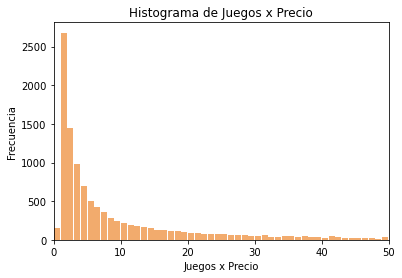

In [44]:
intervalos = range(min(data2.price.values), max(data2.price.values) + 2) #calculamos los extremos de los intervalos

plot.title('Histograma de Juegos x Precio')
#plot.hist(x=data2.cnt_juegosxusuarios, bins=intervalos, color='#F2AB6D', rwidth=0.85)
plot.hist(x=data2.price.values, bins=intervalos, color='#F2AB6D', rwidth=0.90)
plot.xlim([0, 50])
plot.xlabel('Juegos x Precio')
plot.ylabel('Frecuencia')
#plot.xticks(intervalos)
#for rect in axes[0].patches:
#    axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
plot.show()

In [45]:
intervalos

range(0, 18375)

In [82]:
mergeado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779951 entries, 0 to 779950
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   username        779933 non-null  object 
 1   product_id      779951 non-null  int64  
 2   index           779951 non-null  int64  
 3   publisher       770463 non-null  object 
 4   genres          775928 non-null  object 
 5   app_name        779951 non-null  object 
 6   title           779951 non-null  object 
 7   url             779951 non-null  object 
 8   release_date    778840 non-null  object 
 9   tags            779947 non-null  object 
 10  discount_price  1359 non-null    float64
 11  reviews_url     779951 non-null  object 
 12  specs           775923 non-null  object 
 13  price           773278 non-null  object 
 14  early_access    779951 non-null  bool   
 15  id              779951 non-null  int64  
 16  developer       774163 non-null  object 
 17  sentiment 

In [46]:
df = mergeado.dropna(subset=['price'], inplace=False)
df['price'].value_counts()

19.99           152248
Free to Play    108397
9.99            102535
14.99            84039
29.99            53355
                 ...  
1.5                  1
11.15                1
1.59                 1
1.29                 1
399.0                1
Name: price, Length: 111, dtype: int64

In [47]:
df.shape

(773278, 27)

In [48]:
#df['price'] = df['price'].astype('int')
##data_games['id'] = data_games['id'].astype('int')
#df['price'] 
df[df["price"] == "0"].price.count()

0

In [50]:
# Obtenemos los valores que toma la variable price
df['price'].unique()

array([2.99, 14.99, 9.99, 19.99, 4.99, 0.99, 5.99, 11.99, 7.99, 3.99,
       'Free to Play', 29.99, 1.99, 18.99, 8.99, 39.99, 13.99, 6.99,
       'Free To Play', 'Free', 20.0, 59.99, 12.99, 15.99, 24.99,
       'Play for Free!', 1.87, 16.99, 49.99, 17.99, 44.99, 10.99, 5.65,
       99.99, 34.99, 64.99, 0.5, 0.89, 119.99, 0.49, 10.96, 1.29, 79.99,
       189.96, 74.99, 15.0, 2.97, 4.0, 11.15,
       'Play WARMACHINE: Tactics Demo', 4.68, 12.89, 'Play the Demo',
       54.99, 31.99, 'Free Mod', 49.0, 13.98, 44.98, 74.76, 32.99, 4.49,
       189.0, 0.98, 202.76, 61.99, 13.37, 3.0, 69.99, 'Free to Use', 1.59,
       87.94, 149.99, 'Install Now', 7.49, 16.06, 3.49, 19.98,
       'Free to Try', 3.33, 23.96, 21.99, 399.99, 6.66, 1.95, 19.95,
       'Starting at $449.00', 2.49, 139.92, 199.0, 23.99, 12.0, 1.0, 9.95,
       'Third-party', 2.0, 160.91, 20.99, 10.0, 299.99, 26.99, 1.5,
       'Free Movie', 399.0, 14.95, 29.96, 771.71, 59.95, 2.3,
       'Free HITMAN™ Holiday Pack', 6.48], dtype=o

In [51]:
#lista_free = ['Free To Play','Free','Play WARMACHINE: Tactics Demo', 'Install Now','Free to Try','Free Mod','Play WARMACHINE: Tactics Demo','Free HITMAN™ Holiday Pack','Free to Play','Play the Demo','Third-party','Free Movie']
#lista_cost = ['Starting at $449.00']
lista_free = ['Free to Play','Free To Play', 'Free','Play for Free!','Play WARMACHINE: Tactics Demo','Play the Demo','Free Mod','Free to Use','Install Now','Free to Try','Third-party','Free Movie', 'Free HITMAN™ Holiday Pack']
lista_cost = ['Starting at $449.00']

In [53]:
##df.reset_index(inplace=True)
#df2 = df.loc[df['price'].isin(lista_free)]
#df2.shape
##df['price'] = df.loc[df['price'].isin(lista_free)]

Convertimos los valores que machean en la lista lista_free en 0

In [54]:
#df.loc[df['price'] == lista_free, 'price'] = '0'
#df.reset_index(inplace=True)
df.loc[df["price"].isin(lista_free), "price"] = "0"
df[df["price"] == "0"].price.count()

/home/gonperez/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


148181

Seteamos el valor de price en el valor míninmo 449 del precio de jueo para los que están en la lista_cost

In [56]:
#df.loc[df['price'] == lista_cost, 'price'] = '449'
df.loc[df["price"].isin(lista_cost), "price"] = "449"

Convierto price de object to int

In [68]:
#df.reset_index(drop=True,inplace=True)
df = df.copy()
df['price'] = df['price'].astype('int')

In [80]:
df['price'].unique()

array([  2,  14,   9,  19,   4,   0,   5,  11,   7,   3,  29,   1,  18,
         8,  39,  13,   6,  20,  59,  12,  15,  24,  16,  49,  17,  44,
        10,  99,  34,  64, 119,  79, 189,  74,  54,  31,  32, 202,  61,
        69,  87, 149,  23,  21, 399, 449, 139, 199, 160, 299,  26, 771])

In [81]:
# Creo un dataframe con los Precios de los juegos
#df_prices = df['price'].unique()
#df_p = pd.DataFrame(df_prices)
#df_p = df_p.astype('int')
#df_p.sort_values(by=0)

Distribucion de los precios de los juegos

In [83]:
#sns.distplot(df_p)
#plot.xlim([0, 3000])
#sns.histplot(df_p)

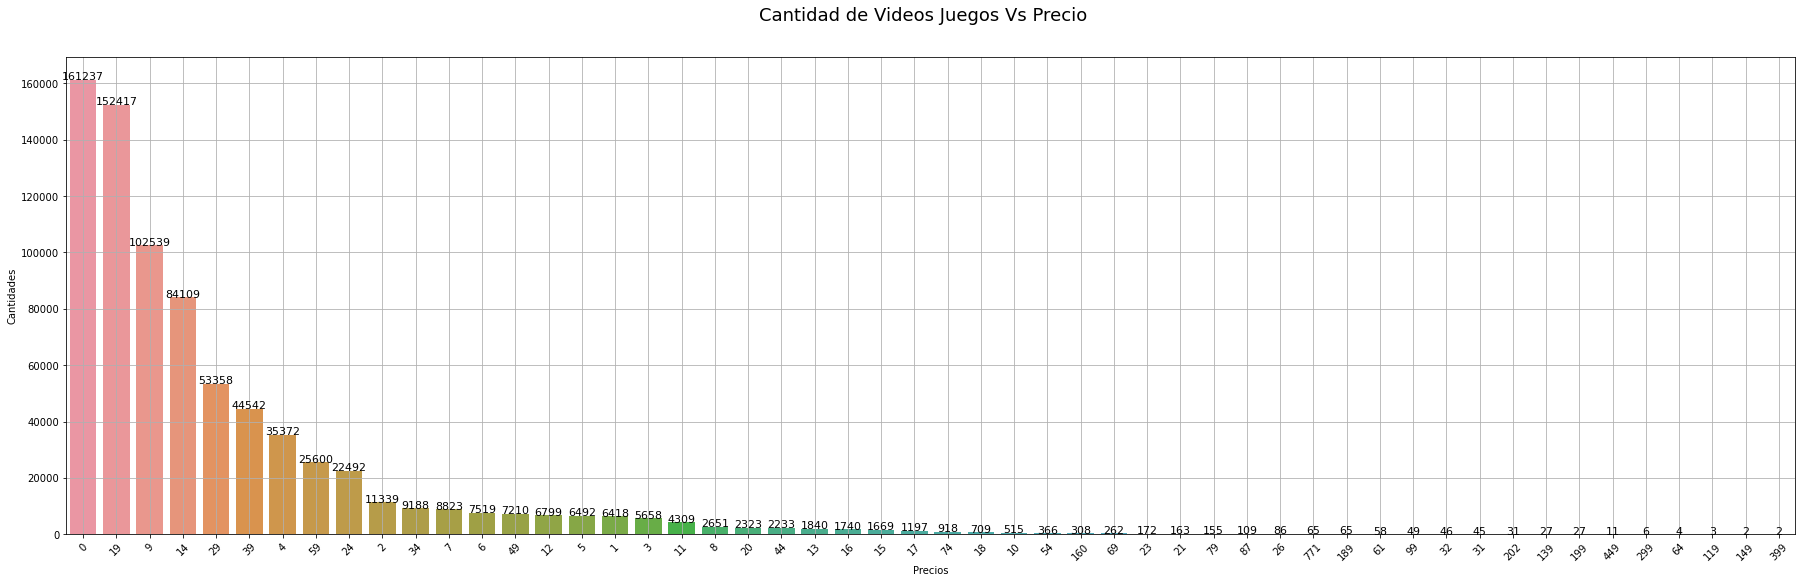

In [99]:
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,1, figsize=(25, 8))
fig.suptitle('Cantidad de Videos Juegos Vs Precio', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)

# GRacount 0
sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes.set_xlabel("Precios")
axes.set_ylabel("Cantidades")
plt.grid()

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

#Grafico 1
#sns.countplot(data = df, x = "pr", orient='v', ax=axes[1], order = df['property_type_2'].value_counts().index)
#axes[1].set_title("Agrupados: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[1])
#plt.xticks(rotation=45)
#plt.grid()

#for rect in axes[1].patches:
#    axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

Se observa la ditribución de los precios de los juegos, los que figuran con valor 0, son los juegos free o demos

bineado de los precios de los juegos con rangos

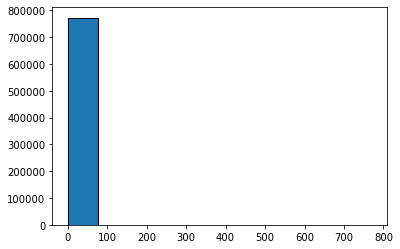

In [79]:
#create histogram with equal-width bins
n, bins, patches = plt.hist(df['price'], edgecolor='black')
plt.show()

#### Binary encoding:

In [73]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(df['price'])
#LabelBinarizer()
lb.classes_
lb.transform([1, 6])

TypeError: '<' not supported between instances of 'str' and 'float'

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773278 entries, 0 to 779950
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   username        773260 non-null  object 
 1   hours           770681 non-null  float64
 2   products        771745 non-null  float64
 3   product_id      773278 non-null  int64  
 4   page_order      773278 non-null  int64  
 5   date            773278 non-null  object 
 6   text            771448 non-null  object 
 7   early_access_x  773278 non-null  bool   
 8   page            773278 non-null  int64  
 9   user_id         314955 non-null  float64
 10  index           773278 non-null  int64  
 11  publisher       763853 non-null  object 
 12  genres          769272 non-null  object 
 13  app_name        773278 non-null  object 
 14  title           773278 non-null  object 
 15  url             773278 non-null  object 
 16  release_date    772167 non-null  object 
 17  tags      